# Amazon Simple Storage Service (S3)

## Introduction

Amazon Simple Storage Service (S3) is one of the flagship services from AWS. In this lesson we'll discuss how you might use it as a data scientist!


## Objectives

You will be able to:

* Describe use cases for S3 buckets in data science
* Create S3 buckets and upload data
* Access data in S3 buckets with Python code

## S3 Buckets in Data Science

### Limitations of GitHub

At this point in the program, you might have encountered an error message like this more than once:

<pre style="color:red">
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com
remote: error: Trace: 08740bd2fb02f980041be67b73e715a9
remote: error: See http://git.io/iEPt8g for more information.
remote: error: File is 218.83 MB; this exceeds GitHub's file size limit of 100.00 MB
! [remote rejected] master -> master (pre-receive hook declined)
error: failed to push some refs
</pre>

This happens when you try to push a file that exceeds GitHub's [file size limits](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-large-files-on-github). The file might contain data in CSV or JSON format, or maybe a pickled ML model.

The short-term workaround is to use `.gitignore` so that the file or files just stay on your computer and are not pushed to GitHub. But that has some limitations:

* If you want someone else to be able to **reproduce** your project and one or more files are too big for GitHub, how do they get the file(s)? You would need to provide very detailed instructions to make this possible
* If you want to **train your model in the cloud** and your data is too big for GitHub, how will your code access the data?
* If you want to **productionize your model** and your pickled model is too big for GitHub, how will your code access the model?

This problem is also not limited to GitHub. Some cloud notebooks do not support standard file systems at all, and some deployment approaches have file size limitations that are much more restrictive than GitHub's!

Fortunately, while these tools might not be optimized for larger files, S3 buckets are a great alternative.

### Recommended S3 Setup for Data Science

For your projects, let's assume you are:

* Working from a Jupyter notebook locally
* Not concerned about access or keeping data private
* Not needing to dynamically upload data (e.g. allow users to upload photos)

Therefore we recommend that you follow this S3 setup:

1. Set up an S3 bucket where objects are all publicly readable
2. When you encounter or create a file that is too big for GitHub, [upload files to S3](https://docs.aws.amazon.com/AmazonS3/latest/userguide/upload-objects.html)
   1. For files below 160 GB, use the AWS Console (web browser interface)
   2. For files between 160 GB and 5 TB, use `boto3` (the AWS Python SDK)
3. Use `boto3` in your Python code to access data in your bucket

Now we will go over all of these steps!

## Creating and Configuring S3 Buckets

In some software applications, S3 buckets are created dynamically based on application context. For data science, projects don't typically need to be quite so dynamic, so we can create our S3 buckets using the more-intuitive AWS console interface rather than using code.

Go to the **S3 management console**. This can be accessed by searching for "s3" in the [AWS Management Console](https://aws.amazon.com/console/) or by going directly to [this link](https://s3.console.aws.amazon.com/s3/home).

Click on **"Create Bucket"**.

Give your bucket a **unique name**:

* If you're working on a specific project, try giving the bucket a name that relates to the project
* DO NOT include any private/secret information in the bucket name
* If someone else has already used a bucket name, you will not be able to use it
  * If you're feeling stuck brainstorming a name, try adding today's date to it. That will be less likely to already be in use
  
Scroll down and **un-check "Block all public access"**. AWS assumes that you want your data to be private, but we are moving forward with the assumption that public data access is not a problem. You will also need to check the box next to **I acknowledge that the current settings might result in this bucket and the objects within becoming public**.

Scroll the rest of the way down and click **Create Bucket**.

Now you should have a bucket set up where objects can be public!

## Uploading Data to S3 Buckets

### AWS Console Approach

For files below 160 GB, you can use the AWS Management Console. Go to the **S3 management console** and click on the name of your bucket.

By default, you should see the "Objects" tab. Click on **Upload**. Click **Add Files** and use the file picker to select a file or multiple files on your computer.

Scroll down to **Permissions** and click to expand. Under "Predefined ACLs", click **Grant public-read access** and then check the box next to **I understand the risk of granting public-read access to the specified objects**.

Scroll to the bottom and click **Upload**. You will be taken to an upload status page while the file is being uploaded, then you can click **Close**.

### Checking for Successful Upload and Configuration

Now your data should be publicly hosted on S3! Try clicking on the file name in the "Objects" tab to see all of the information about it.

To test whether the file permissions were successfully set to be public, you can click on either the "Open" button in the upper right, or the "Object URL" link inside the "Object Overview" panel.

#### Successful Upload

If your file is downloaded, that means the settings are correct. (If it is a very large file, feel free to stop the download to save time and space -- you already have the file on your computer!)

#### Unsuccessful Upload

If you see a message like this:

> This XML file does not appear to have any style information associated with it. The document tree is shown below.

```
<Error>
<Code>AccessDenied</Code>
<Message>Access Denied</Message>
<RequestId>XXXXXXXXXXXXXXXX</RequestId>
<HostId>XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX</HostId>
</Error>
```

That means that you did not configure the permissions correctly. Go back through and make sure that:

* The bucket settings are configured so that objects can be public
  * If you look at the bucket from the [S3 management console](https://s3.console.aws.amazon.com/s3/home), you should see the text "Objects can be public" in the "Access" column
  * If you do not see that, click on the bucket, go to the **Permissions** tab, scroll down to **Block public access (bucket settings)**, and click **Edit**. Un-check **Block all public access**, check **I acknowledge that the current settings might result in this bucket and the objects within becoming public**, and click **Save Changes**
* The object settings are configured so that the public can access them
  * If you click on the bucket name, then click on the name of the file (e.g. `test.csv`), then go to the **Permissions** tab, you should see "Read" in the "Object" column next to "Everyone (public access)"
  * If you do not see that, click on **Edit** next to "Access control list (ACL)". Locate the row that says "Everyone (public access)" and the column that says "Objects", and click the checkbox next to **Read**. Scroll down and click the checkbox next to **I understand the effects of these changes on this object**, then click **Save changes**
  
### Python Approach

For files from 160 GB to 5 TB, you'll need a more sophisticated approach. Check out [this documentation](https://docs.aws.amazon.com/AmazonS3/latest/userguide/mpuoverview.html) for an overview of the multi-part upload process.

Fortunately you can use `boto3`, the same package we'll use in the later examples in this lesson, in order to achieve this. First, use [this documentation](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#configuration) to configure a file on your computer to give `boto3` the credentials it needs to upload. Then follow the documentation [here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.create_multipart_upload) to create the actual upload.

## Accessing Data in S3 Buckets

As demonstrated above, one way to access the data in your S3 bucket is simply to navigate the the relevant web address and download the file. However, our main goal is to make the data accessible in **Python code**, not using a web browser. To achieve that, we'll use the `boto3` library!

![boto3](https://curriculum-content.s3.amazonaws.com/data-science/images/boto3.png)

Boto 3 is a library that allows Python developers to access many different Amazon web services, not just S3. You can find the full list [here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/index.html). But we'll focus on using S3 with `boto3` because that is one of the most common use cases for data scientists.

(The name "boto" is a type of dolphin that is native to the Amazon river. [According to its developer](https://github.com/boto/boto3/issues/1023#issuecomment-287127647), "I wanted something short, unusual, and with at least some kind of connection to Amazon".)

### Installing `boto3`

This library is not part of `learn-env` as of this writing. If you are working on a project, we recommend activating that project `conda` environment. Or if you're just wanting to learn about `boto3`, you can un-comment this line of code to install it in your current environment:

In [ ]:
# !conda install boto3 -y

Make sure this cell runs successfully before proceeding:

In [1]:
import boto3
s3 = boto3.resource("s3")

### Connecting to an Example S3 Bucket

For the purposes of this curriculum, we have loaded some example files into an S3 bucket for you! Let's go through those examples, starting with a text file.

#### Text File

We'll instantiate an instance of the [`Object` class](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html?highlight=s3.object#S3.Object) by passing in those string values. The first one, `bucket_name`, is the name of the bucket. The second, `key`, is the name of the object (file) inside that bucket.

In [2]:
txt_obj = s3.Object("curriculum-content", "data-science/data/zen_of_python.txt")
txt_obj

s3.Object(bucket_name='curriculum-content', key='data-science/data/zen_of_python.txt')

This object is used kind of like a request in the `requests` library. You call the [`get` method](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html?highlight=s3.object#S3.Object.get) to initiate an HTTP `GET` request.

In [3]:
txt_resp = txt_obj.get()
txt_resp

{'ResponseMetadata': {'RequestId': 'JR1N0QAM82W3ETVW',
  'HostId': 'J2J6MiFzynwLLLlOXBSTgYyFOPcDpoofyc165VnBbB+nNEH2cbovo7p4+MGMYXiT0mfD8acVZ2o=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'J2J6MiFzynwLLLlOXBSTgYyFOPcDpoofyc165VnBbB+nNEH2cbovo7p4+MGMYXiT0mfD8acVZ2o=',
   'x-amz-request-id': 'JR1N0QAM82W3ETVW',
   'date': 'Thu, 10 Mar 2022 20:58:09 GMT',
   'last-modified': 'Thu, 10 Mar 2022 19:17:44 GMT',
   'etag': '"760dcb2a44c5b0553ee12ea8cca057b8"',
   'x-amz-server-side-encryption': 'AES256',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '858'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 3, 10, 19, 17, 44, tzinfo=tzutc()),
 'ContentLength': 858,
 'ETag': '"760dcb2a44c5b0553ee12ea8cca057b8"',
 'ContentType': 'binary/octet-stream',
 'ServerSideEncryption': 'AES256',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x10ad09128>}

The actual data for the object is contained in the "Body" of the response. Let's extract that key and read out the data:

In [4]:
txt_body = txt_resp["Body"].read().decode()
print(txt_body)

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!




#### More-Complex Files: `BytesIO`

If we have a file type where we want to do something other than just print out its contents (e.g. images, pickled models, CSVs), we need to add one more step: creating a virtual file with `BytesIO` (a class in the built-in [Python `io` module](https://docs.python.org/3/library/io.html)). Then we can send that virtual file to a library like Pillow, `joblib`, or `pandas`.

#### Image File

`learn-env` already has Pillow, but un-comment the following line if you need to install it in the environment you're currently using to look at this example. Or you can feel free to skip this example and go down to the next one!

In [ ]:
# !conda install pillow -y

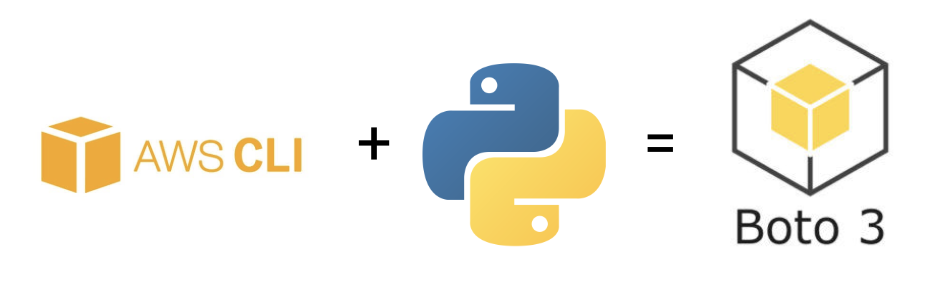

In [5]:
from io import BytesIO
from PIL import Image

# Getting the same boto3 image that appears earlier in this lesson
img_obj = s3.Object("curriculum-content", "data-science/images/boto3.png")
# Get the response
img_resp = img_obj.get()
# Read the data into a BytesIO object
img_bytes = BytesIO(img_resp["Body"].read())
# Display the image using Pillow
image = Image.open(img_bytes)
display(image)

This is a bit silly example (displaying image data in a Jupyter notebook) but the same approach could be used for loading data into an image classification tool! Check out [this blog post](https://medium.com/analytics-vidhya/custom-keras-generator-fetching-images-from-s3-to-train-neural-network-4e98694de8ee) for an example.

#### Pickled Model

Some model algorithms (e.g. Random Forest, Neural Networks) produce very large pickled models that don't easily fit into GitHub. And in some cases, your deployment approach will not have a file system available, so you'll need to use a cloud storage technique regardless of the model size. Below we show an example of a fairly simple linear regression model that has been stored in S3, but the same concept can easily apply to larger, more-complex models:

In [6]:
import warnings
warnings.filterwarnings('ignore') 

from io import BytesIO
from sklearn.linear_model import LinearRegression
import joblib

# Initialize S3 object
pkl_obj = s3.Object("curriculum-content", "data-science/models/regression_model.pkl")
# Get the response
pkl_resp = pkl_obj.get()
# Read the data into BytesIO object
pkl_bytes = BytesIO(pkl_resp["Body"].read())
# Load the data using joblib
loaded_model = joblib.load(pkl_bytes)
loaded_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
print(f"Loaded model is y = {loaded_model.coef_[0]}x + {loaded_model.intercept_}")

loaded_model.predict([[10], [11], [12]])

Loaded model is y = 1.0x + 1.0


array([11., 12., 13.])

#### CSV File

CSV data is a more realistic file type you might be working with. The below example reads a CSV file from an S3 bucket, then loads it into `pandas`:

In [8]:
from io import BytesIO
import pandas as pd

# Initialize S3 object
csv_obj = s3.Object("curriculum-content", "data-science/data/test.csv")
# Get the response
csv_resp = csv_obj.get()
# Read the data into a BytesIO object
csv_bytes = BytesIO(csv_resp["Body"].read())
# Load the data with pandas
df = pd.read_csv(csv_bytes)
df

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,1700,1,1.9,0,0,1,54,0.5,170,...,17,644,913,2121,14,8,15,1,1,0
996,997,609,0,1.8,1,0,0,13,0.9,186,...,2,1152,1632,1933,8,1,19,0,1,1
997,998,1185,0,1.4,0,1,1,8,0.5,80,...,12,477,825,1223,5,0,14,1,0,0
998,999,1533,1,0.5,1,0,0,50,0.4,171,...,12,38,832,2509,15,11,6,0,1,0


#### Avoiding `BytesIO` by Installing S3Fs

If you are using `pandas` and you want to avoid having to use `BytesIO`, there is a library called [S3Fs (S3 Filesystem)](https://s3fs.readthedocs.io/en/latest/) that can help you shorten the above code by treating S3 URLs as regular file system URLs. You just need to start the file path with `"s3://"`!

(S3Fs is used "under the hood" by `pandas` and does not require a separate import for this type of use.)

In [ ]:
# !conda install s3fs -c conda-forge -y

Here is the same example as above, using S3Fs to shorten the code:

In [9]:
import pandas as pd
df = pd.read_csv("s3://curriculum-content/data-science/data/test.csv")
df

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,1700,1,1.9,0,0,1,54,0.5,170,...,17,644,913,2121,14,8,15,1,1,0
996,997,609,0,1.8,1,0,0,13,0.9,186,...,2,1152,1632,1933,8,1,19,0,1,1
997,998,1185,0,1.4,0,1,1,8,0.5,80,...,12,477,825,1223,5,0,14,1,0,0
998,999,1533,1,0.5,1,0,0,50,0.4,171,...,12,38,832,2509,15,11,6,0,1,0


### Connecting to Your S3 Bucket

In the cell below, replace the string values with the names of your S3 bucket and the file you want to read:

In [ ]:
bucket_name = ""
object_name = ""

Now we'll attempt to load your object using `boto3`:

In [ ]:
obj = s3.Object(bucket_name, object_name)
obj

In [ ]:
response = obj.get()
response

(If you get a `NoCredentialError` here, that means that you either have the wrong bucket or object name, or you did not set the permissions on the bucket or object correctly. Double-check that the steps above are working as expected.)

Now you can continue with whatever next steps are appropriate for your use case!

## Summary

In this lesson, we introduced the use cases for S3 in data science: typically data scientists use S3 for storing files that are too big for GitHub, but still need to be accessible from Python code for the purposes of reproducibility, using certain cloud services, or deployment. These can include many types of files, including text, images, pickled models, and data files such as CSV.

We recommend that you use the AWS console to upload content to a bucket and configure the access permissions, then use the `boto3` Python library to access this content from the context of Python code.